# Numpy neural network implementation
This notebook contains code to train and evaluate a numpy implementation of a neural network on the MNIST dataset. First and example is given where each layer is defined using the `LinearLayer` class from `linearnn.linearclasses`; then the `SequentialModel` class from the same module is used to build/train a numpy neural network.

In [2]:
from sklearn.datasets import fetch_openml # load MNIST data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math # for exp in sigmoid

# 1. Load MNIST Dataset
<img src='media/MNIST_examples.png' alt='MNIST examples'>

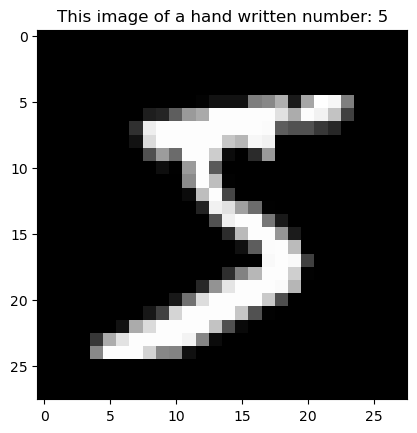

In [3]:
# load data from sklearn
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target'] # two dataframes
y_one_hot_array = pd.get_dummies(y, prefix='class').to_numpy().astype(int) # do onehot encoding
# plot first example
image = X.iloc[0].values.reshape(28, 28) # reshape it to the form of an image
label = y.iloc[0]
plt.title(f'This image of a hand written number: {label}')
plt.imshow(image, cmap='gray')

## Weight initializations

In [4]:
def xavier_init(size): # recommened for tanh
    in_dim, out_dim = size
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, size)


def he_init(size):
    in_dim, _ = size
    stddev = np.sqrt(2 / in_dim)
    return np.random.normal(0, stddev, size)

# 2. Train NN using LinearLayer class to define network layers
This code sell uses a linear layer class to define a neural network and train it on the MNIST dataset

In [15]:
# Declare simple network
import importlib
from linearnn import linearnnclasses
importlib.reload(linearnnclasses)
from linearnn import activationfunctions
from linearnn import lossfunctions

importlib.reload(activationfunctions)
from linearnn.activationfunctions import ReLU, SELU, Tanh, DummyActivation
from linearnn.optim import AdamOptimizer

hidden_layer_sizes = (784, 784, 784) 
# hidden_layer_sizes = (1024, 512, 256) 
# hidden_layer_sizes = (512, 256, 128)
# hidden_layer_sizes = (256, 128, 64)
# hidden_layer_sizes = (128, 64, 28)

learning_rate = 0.0001


hiddenlayer01 = linearnnclasses.LinearLayer(
    input_size=784, 
    output_size=hidden_layer_sizes[0], 
    activation_fn_class=ReLU, 
    weight_init=he_init,
    learning_rate=learning_rate,
    optimizer=AdamOptimizer # a seperate instace for each layer cuz each layer is a different shape
)

# dropoutlayer01 = linearnnclasses.DropoutLayer(dropout_rate=0.05)

hiddenlayer02 = linearnnclasses.LinearLayer(
    input_size=hidden_layer_sizes[0], 
    output_size=hidden_layer_sizes[1], 
    activation_fn_class=SELU, 
    weight_init=he_init,
    learning_rate=learning_rate,
    optimizer=AdamOptimizer
)

hiddenlayer03 = linearnnclasses.LinearLayer(
    input_size=hidden_layer_sizes[1], 
    output_size=hidden_layer_sizes[2], 
    activation_fn_class=Tanh, 
    weight_init=xavier_init, # this init is for tanh activation
    learning_rate=learning_rate,
    optimizer=AdamOptimizer
)

outputlayer = linearnnclasses.LinearLayer(
    input_size=hidden_layer_sizes[2], 
    output_size=10, 
    activation_fn_class=DummyActivation, # dummy activation because softmax is incorperated into the loss function
    weight_init=he_init,
    learning_rate=learning_rate,
    optimizer=AdamOptimizer
)



num_epochs = 500
batch_size = 1_000

split_position = 50_000 # 70k examples total
valid_size = 5_000
# test set
X_test = X.iloc[split_position+valid_size:].values / 255
y_test = y_one_hot_array[split_position+valid_size:,:]
y_truth_test = np.argmax(y_test, axis=1) # convert from onehot to just the correct number
# validation set
X_valid = X.iloc[split_position - valid_size:split_position].values / 255
y_valid = y_one_hot_array[split_position - valid_size:split_position]
y_truth_valid = np.argmax(y_valid, axis=1) # convert from onehot to just the correct number

train_losses = []
val_losses = []
val_accuracies = []
epochs = list(range(num_epochs)) # if stopping training prematurely this could be an issue

training_loss_class = lossfunctions.CategoricalCrossEntropy(l2_lambda=0)

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    batch_counter = 0 # keep track of number of epochs to get average of training losses
    for i in range(0, X.iloc[0:split_position].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]

        # forwaed pass
        hidden_output = hiddenlayer01.forward(x_batch, backprop=True)
        # hidden_output = dropoutlayer01.forward(hidden_output, training=True)
        hidden_output = hiddenlayer02.forward(hidden_output, backprop=True)
        hidden_output = hiddenlayer03.forward(hidden_output, backprop=True)

        y_hat = outputlayer.forward(hidden_output, backprop=True) # do forward pass saving inputs at each step


        # compute loss
        loss = training_loss_class.forward(y=y_batch, y_hat=y_hat, weights=outputlayer.weights)
        running_loss += loss


        # back propagation
        loss_gradient = training_loss_class.derivative(y=y_batch, y_hat=y_hat)

        output_layer_gradient = outputlayer.backward(output_gradient=loss_gradient)#, y = y_batch) # have to pass y for derivative of soft max

        hidden_layer_gradient = hiddenlayer03.backward(output_gradient=output_layer_gradient)      
        hidden_layer_gradient = hiddenlayer02.backward(output_gradient=hidden_layer_gradient)  
        # hidden_layer_gradient = dropoutlayer01.backward(output_gradient =hidden_layer_gradient)    
        hidden_layer_gradient = hiddenlayer01.backward(output_gradient=hidden_layer_gradient)      





        batch_counter += 1


    running_loss /= batch_counter # get average of batch losses for the epoch
    train_losses.append(running_loss)

    # predicted_nums = np.argmax(y_hat, axis=1)
    # correct_predictions = np.sum(predicted_nums == y_truth)
    # train_accuracy = correct_predictions / y_truth.shape[0]
    


    # Evaluation on Test set (only done once per epoch)
    hidden_output = hiddenlayer01.forward(X_valid, backprop=False) # back prop as false because no need store intermediate values
    hidden_output = hiddenlayer02.forward(hidden_output, backprop=False)
    hidden_output = hiddenlayer03.forward(hidden_output, backprop=False)
    y_hat = outputlayer.forward(hidden_output, backprop=False) # back prop as false because no need store intermediate values
    
    val_loss = lossfunctions.CategoricalCrossEntropy(l2_lambda=0.0).forward(y=y_valid, y_hat=y_hat)
    val_losses.append(val_loss)

    predicted_nums = np.argmax(y_hat, axis=1)
    correct_predictions = np.sum(predicted_nums == y_truth_valid)
    val_accuracy = correct_predictions / y_truth_valid.shape[0]
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, train loss: {running_loss:0.3f}, validation loss: {val_loss:0.3f}, train acc: {None}, validation acc: {val_accuracy:0.3f}')


# evaluation on held out test set

hidden_output = hiddenlayer01.forward(X_test, backprop=False) # back prop as false because no need store intermediate values
hidden_output = hiddenlayer02.forward(hidden_output, backprop=False)
hidden_output = hiddenlayer03.forward(hidden_output, backprop=False)
y_hat = outputlayer.forward(hidden_output, backprop=False) # back prop as false because no need store intermediate values

test_loss = lossfunctions.CategoricalCrossEntropy(l2_lambda=0.0).forward(y=y_test, y_hat=y_hat)


predicted_nums = np.argmax(y_hat, axis=1)
correct_predictions = np.sum(predicted_nums == y_truth_test)
test_accuracy = correct_predictions / y_truth_test.shape[0]

print(f'Model training complete with test loss: {test_loss} and 01 loss: {test_accuracy}')


Epoch: 0, train loss: 0.562, validation loss: 0.299, train acc: None, validation acc: 0.907
Epoch: 1, train loss: 0.301, validation loss: 0.303, train acc: None, validation acc: 0.908
Epoch: 2, train loss: 0.313, validation loss: 0.327, train acc: None, validation acc: 0.902
Epoch: 3, train loss: 0.349, validation loss: 0.454, train acc: None, validation acc: 0.849
Epoch: 4, train loss: 0.396, validation loss: 0.379, train acc: None, validation acc: 0.892
Epoch: 5, train loss: 0.341, validation loss: 0.330, train acc: None, validation acc: 0.907
Epoch: 6, train loss: 0.323, validation loss: 0.318, train acc: None, validation acc: 0.907
Epoch: 7, train loss: 0.316, validation loss: 0.308, train acc: None, validation acc: 0.907
Epoch: 8, train loss: 0.297, validation loss: 0.303, train acc: None, validation acc: 0.911
Epoch: 9, train loss: 0.293, validation loss: 0.298, train acc: None, validation acc: 0.914
Epoch: 10, train loss: 0.281, validation loss: 0.295, train acc: None, validatio

In [20]:
hidden_output = hiddenlayer01.forward(X_test, backprop=False) # back prop as false because no need store intermediate values
hidden_output = hiddenlayer02.forward(hidden_output, backprop=False)
hidden_output = hiddenlayer03.forward(hidden_output, backprop=False)
y_hat = outputlayer.forward(hidden_output, backprop=False) # back prop as false because no need store intermediate values

test_loss = lossfunctions.CategoricalCrossEntropy(l2_lambda=0.0).forward(y=y_test, y_hat=y_hat)


predicted_nums = np.argmax(y_hat, axis=1)
correct_predictions = np.sum(predicted_nums == y_truth_test)
test_accuracy = correct_predictions / y_truth_test.shape[0]

print(f'Model training complete with test loss: {test_loss} and 01 loss: {test_accuracy}')

# save model
layers = [hiddenlayer01, hiddenlayer02, hiddenlayer03, outputlayer]
import joblib
joblib.dump(layers, r'trained_layers_final_model.pkl')

Model training complete with test loss: 0.18301609385262657 and 01 loss: 0.9467333333333333


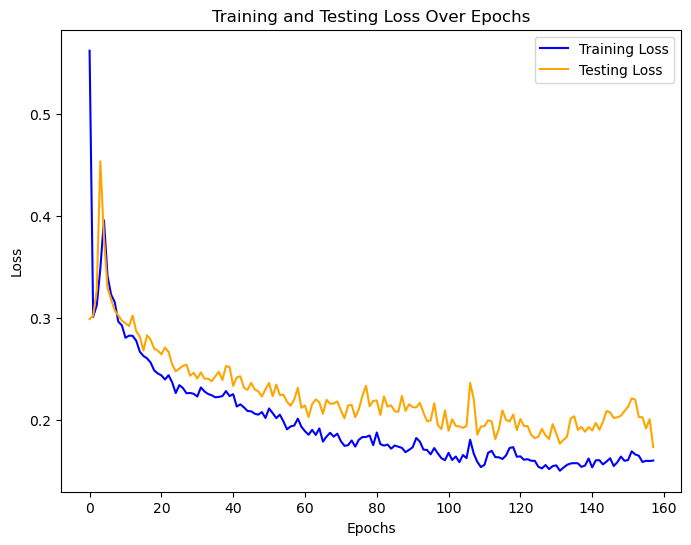

In [22]:
# training convergence plot

import matplotlib.pyplot as plt

epochs = list(range(len(val_losses))) # just incase it was stopped early

plt.figure(figsize=(8, 6))

plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker=None) # training loss line

plt.plot(epochs, val_losses, label='Validations Loss', color='orange', marker=None) # test loss line

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

# 3. Use SequentialModel class to build numpy NN

In [19]:
from linearnn import linearnnclasses
from linearnn import lossfunctions
from linearnn.activationfunctions import ReLU, SELU, Tanh, DummyActivation
# from linearnn.optim import AdamOptimizer
from linearnn import optim
import importlib
importlib.reload(linearnnclasses)
importlib.reload(optim)




sequential_model = linearnnclasses.SequentialModel(
    input_size=784,
    output_size=10,
    hidden_layers=(512, 256, 128), 
    activation_fn_classes=(ReLU, SELU, Tanh, DummyActivation),
    weight_init=(he_init, he_init, xavier_init, he_init),
    loss_fn_class = lossfunctions.CategoricalCrossEntropy,
    learning_rate = 0.07,
    optimizer=None#optim.AdamOptimizer # with default settings (see linearnn/optim.py)
)
# sequential_model.forward(x_batch)
# sequential_model.backward(x_batch, y_one_hot_array[0:500, :])

building model...
5
1
Adding: LinearLayer input:784, output:512, activation:<class 'linearnn.activationfunctions.ReLU'>
2
Adding: LinearLayer input:512, output:256, activation:<class 'linearnn.activationfunctions.SELU'>
3
Adding: LinearLayer input:256, output:128, activation:<class 'linearnn.activationfunctions.Tanh'>
4
Adding: LinearLayer input:128, output:10, activation:<class 'linearnn.activationfunctions.DummyActivation'>
model built


# 4. Model Training

In [20]:
num_epochs = 100
batch_size = 500

split_position = 50_000
X_test = X.iloc[split_position:].values / 255
y_test = y_one_hot_array[split_position:,:]
y_truth = np.argmax(y_test, axis=1) # convert from onehot to just the correct number

train_losses = []
test_losses = []
test_accuracies = []
epochs = list(range(num_epochs)) # if stopping training prematurely this could be an issue

test_loss_fn_class = lossfunctions.CategoricalCrossEntropy(l2_lambda=0.0)


for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    for i in range(0, X.iloc[:split_position].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]
        loss = sequential_model.backward(x_batch, y_batch) # forward pass is incorperated in backward function
     
        running_loss += loss
    

    y_hat = sequential_model.forward(X_test, backprop=False)
    test_loss = test_loss_fn_class.forward(y=y_test, y_hat=y_hat)
    test_losses.append(test_loss)

    predicted_nums = np.argmax(y_hat, axis=1)
    correct_predictions = np.sum(predicted_nums == y_truth)
    test_accuracy = correct_predictions / y_truth.shape[0]
    test_accuracies.append(test_accuracy)

    print(f'Epoch: {epoch}, train loss: {running_loss/(X.shape[0]/batch_size):0.3f}, test loss: {test_loss:0.3f}, train acc: {None}, test acc: {test_accuracy:0.3f}')



Epoch: 0, train loss: 1.827, test loss: 2.531, train acc: None, test acc: 0.070
Epoch: 1, train loss: 1.761, test loss: 2.446, train acc: None, test acc: 0.081
Epoch: 2, train loss: 1.706, test loss: 2.372, train acc: None, test acc: 0.096
Epoch: 3, train loss: 1.658, test loss: 2.306, train acc: None, test acc: 0.118
Epoch: 4, train loss: 1.614, test loss: 2.244, train acc: None, test acc: 0.148
Epoch: 5, train loss: 1.573, test loss: 2.186, train acc: None, test acc: 0.186
Epoch: 6, train loss: 1.534, test loss: 2.130, train acc: None, test acc: 0.227
Epoch: 7, train loss: 1.496, test loss: 2.077, train acc: None, test acc: 0.273
Epoch: 8, train loss: 1.461, test loss: 2.026, train acc: None, test acc: 0.320
Epoch: 9, train loss: 1.426, test loss: 1.978, train acc: None, test acc: 0.364
Epoch: 10, train loss: 1.394, test loss: 1.931, train acc: None, test acc: 0.405
Epoch: 11, train loss: 1.362, test loss: 1.886, train acc: None, test acc: 0.443
Epoch: 12, train loss: 1.332, test los

In [ ]:
# training convergence plot

import matplotlib.pyplot as plt

epochs = list(range(len(val_losses))) # just incase it was stopped early

plt.figure(figsize=(8, 6))

plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker=None) # training loss line

plt.plot(epochs, val_losses, label='Testing Loss', color='orange', marker=None) # test loss line

plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()